Import de la base de données

In [2]:
import pandas as pd
import folium
from folium.plugins import HeatMap, MarkerCluster
import numpy as np

# Charger les données depuis le CSV
df = pd.read_csv('https://github.com/PRAJAM/Projet/raw/jules/Export_TER_juin2023_FIX_SafwanChendeb.csv', sep=';')

df.head()


N° ENREG Code CAF  ASS_FRQ_KHZ  ASS_LGBD_KHZ  TER_ANT_AZM_MAX  \
0  1028247.0        K     38577000       14000.0             90.0   
1  1033878.0        K     19376875       13700.0            204.5   
2  1428858.0        K     26145000       56000.0            320.7   
3  1502495.0        K      6920000       40000.0            307.4   
4   339609.0        K     38552500        7000.0            319.9   

   TER_ANT_ANG  PT_LONG_DEG  PT_LONG_MIN  PT_LONG_SEC PT_LONG_ORIENT  \
0          1.7            2           20           59              E   
1          1.9            1           14           59              E   
2          2.6            7            3            5              E   
3          3.0            6           36           33              E   
4          1.7            5           28           44              E   

   PT_LAT_DEG  PT_LAT_MIN  PT_LAT_SEC PT_LAT_ORIENT    Date CAF BASE MVT_CODE  
0          48          53          40             N  01/03/2013    H      MOD  
1          43          16          11             N  18/09/2013    H      MOD  
2          43          37           2             N  18/05/2017    H      ADD  
3          47          38          35             N  11/04/2019    R      ADD  
4          43          29          38             N  10/05/2005    H      MOD

Suppression des antennes qui ont été supprimées, et

In [3]:
df2 = df.dropna(subset=['ASS_LGBD_KHZ'])
df2 = df2[df2["ASS_LGBD_KHZ"] > 1]

enreg_to_supp = df2[df2['MVT_CODE'] == 'SUP']['N° ENREG']
df2 = df2[~df2['N° ENREG'].isin(enreg_to_supp)]

df2['Date CAF'] = pd.to_datetime(df['Date CAF'], format='%d/%m/%Y')
df2 = df2.sort_values('Date CAF').drop_duplicates(subset='N° ENREG', keep='last')

In [4]:
# Fonction vectorisée pour convertir les coordonnées DMS en degrés décimaux
def dms_to_dd(degrees, minutes, seconds, orientation):
    dd = degrees + minutes / 60 + seconds / 3600
    dd[orientation.isin(['W', 'S'])] *= -1
    return dd

# Appliquer la conversion sur les colonnes de latitude et de longitude
df2['latitude'] = dms_to_dd(df2['PT_LAT_DEG'], df2['PT_LAT_MIN'], df2['PT_LAT_SEC'], df2['PT_LAT_ORIENT'])
df2['longitude'] = dms_to_dd(df2['PT_LONG_DEG'], df2['PT_LONG_MIN'], df2['PT_LONG_SEC'], df2['PT_LONG_ORIENT'])

#drop
df2 = df2.drop(['PT_LAT_DEG', 'PT_LAT_MIN', 'PT_LAT_SEC', 'PT_LAT_ORIENT', 'PT_LONG_DEG', 'PT_LONG_MIN', 'PT_LONG_SEC', 'PT_LONG_ORIENT', 'BASE', 'MVT_CODE', 'N° ENREG', 'TER_ANT_ANG', 'TER_ANT_AZM_MAX'], axis=1)

In [ ]:
df2.head()

Code CAF  ASS_FRQ_KHZ  ASS_LGBD_KHZ   Date CAF   latitude  longitude
510318        N        20080           2.0 1947-06-26  48.544444   2.572222
308872        N        20080           2.0 1947-06-26  48.544444   2.572222
81221         N        20080           2.0 1947-06-26  48.544444   2.572222
495875        N        20080           2.0 1947-06-26  48.544444   2.572222
248194        J         5140           6.0 1948-04-16  45.750000   4.833333

In [5]:
#drop ass_frq > 100 000 000
df2 = df2[df2['ASS_FRQ_KHZ'] < 50000000]


#drop ass_lgbd > 200 000
df2 = df2[df2['ASS_LGBD_KHZ'] < 200000]

#encadrer la longitude et latitude : 51.691467, -6.106181 et 41.924975, 8.307881
df2 = df2[(df2['latitude'] >= 41.924975) & (df2['latitude'] <= 51.691467) & (df2['longitude'] >= -6.106181) & (df2['longitude'] <= 8.307881)]


In [ ]:
# Échantillonnage des données pour réduire le nombre de points
sample_fraction = 0.1  # Vous pouvez ajuster cette valeur
df_sample = df2.sample(frac=sample_fraction, random_state=1)

# Créer une carte Folium centrée sur la France avec des tuiles légères
m = folium.Map(location=[46.603354, 1.888334], zoom_start=6, tiles='CartoDB positron')

# Ajouter des clusters de points pour une meilleure visualisation
marker_cluster = MarkerCluster().add_to(m)

# Ajouter les points au cluster
for idx, row in df_sample.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']]).add_to(marker_cluster)

# Préparer les données pour le HeatMap avec intensité
heat_data = [[row['latitude'], row['longitude'], 1] for index, row in df_sample.iterrows()]

# Ajouter le HeatMap à la carte avec des paramètres ajustés pour une meilleure performance et visibilité
HeatMap(heat_data, radius=15, blur=10, max_zoom=12, min_opacity=0.4).add_to(m)

# Sauvegarder la carte dans un fichier HTML
m.save('antennas_heatmap_small.html')

# Afficher la carte dans le notebook
m

Machine learning

In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import MiniBatchKMeans
# Sélection des colonnes numériques et non numériques
numerical_cols = ['ASS_FRQ_KHZ', 'ASS_LGBD_KHZ',
                  'latitude', 'longitude']
categorical_cols = ['Code CAF']  # Exemple de colonnes catégorielles à encoder


# Encodage des colonnes catégorielles
label_encoder = LabelEncoder()

df_encoded = df2.copy()

for col in categorical_cols:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

# Normalisation des données
scaler = StandardScaler()

df_standardized = df_encoded.copy()

df_standardized[numerical_cols] = scaler.fit_transform(df_standardized[numerical_cols])
df_standardized[categorical_cols] = scaler.fit_transform(df_standardized[categorical_cols])
df_standardized['Date CAF'] = scaler.fit_transform(df_standardized[['Date CAF']])
df_standardized['Code CAF'] /= 3

<Axes: >

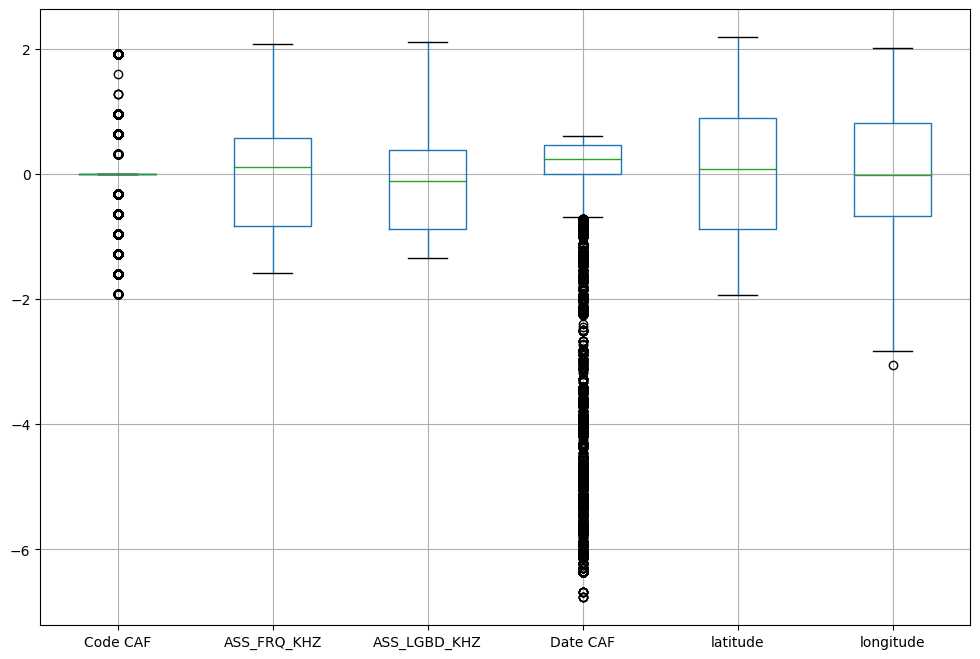

In [ ]:
#plot each column
df_standardized.boxplot(figsize=(12, 8))

<Axes: >

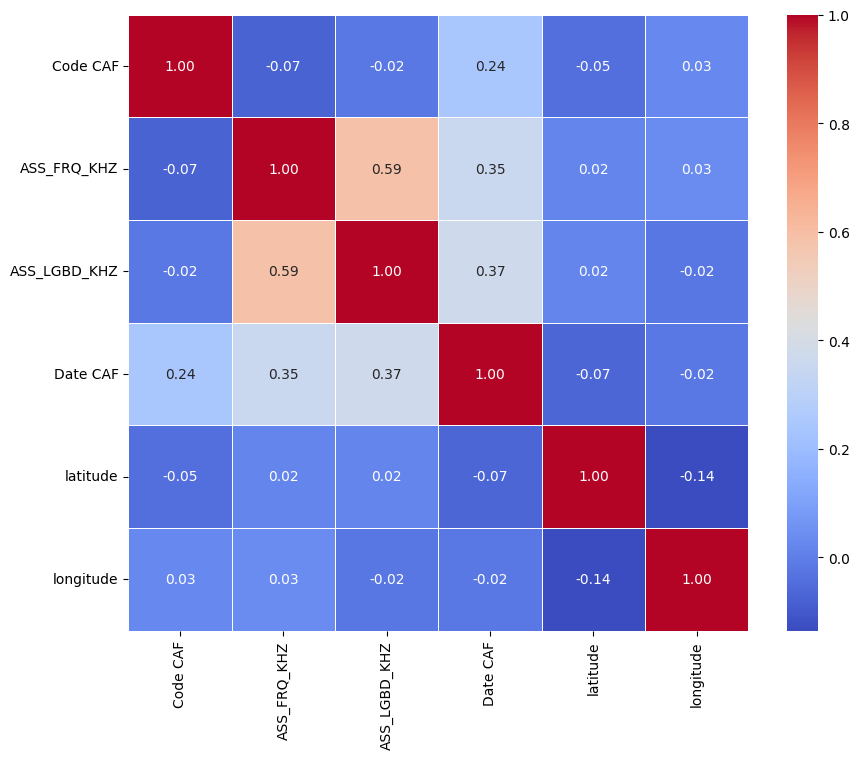

In [ ]:
#matrice de correlation
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df_standardized.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change fr

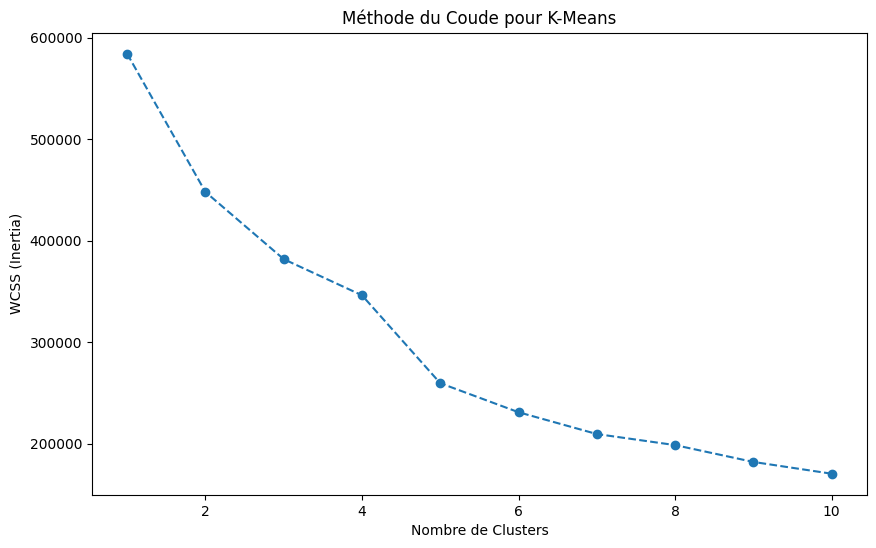

In [ ]:
#import
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

wcss = []
for i in range(1, 11):
    kmeans = MiniBatchKMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_standardized)
    wcss.append(kmeans.inertia_)

# Tracé du coude (Elbow Method)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Nombre de Clusters')
plt.ylabel('WCSS (Inertia)')
plt.title('Méthode du Coude pour K-Means')
plt.show()


In [ ]:
df_standardized.head()
from sklearn.cluster import KMeans

#kmeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(df_standardized)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=5, random_state=42)

array([[<Axes: title={'center': 'ASS_FRQ_KHZ'}, xlabel='[cluster]'>,
        <Axes: title={'center': 'ASS_LGBD_KHZ'}, xlabel='[cluster]'>],
       [<Axes: title={'center': 'Code CAF'}, xlabel='[cluster]'>,
        <Axes: title={'center': 'Date CAF'}, xlabel='[cluster]'>],
       [<Axes: title={'center': 'latitude'}, xlabel='[cluster]'>,
        <Axes: title={'center': 'longitude'}, xlabel='[cluster]'>]],
      dtype=object)

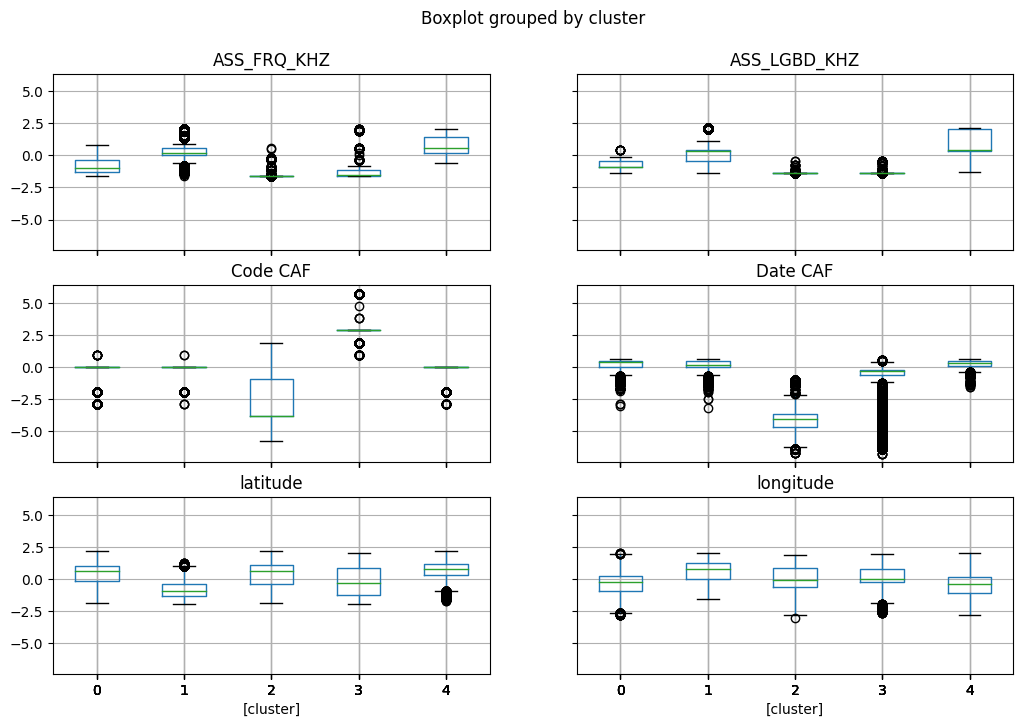

In [ ]:
#boxplot each attribute with clusters
df_standardized['cluster'] = kmeans.labels_
df_standardized.boxplot(by='cluster', figsize=(12, 8))


In [18]:
#scatter df plotly
import plotly.express as px
fig = px.scatter(df2, x='Date CAF', y='ASS_FRQ_KHZ', color="Code CAF")


fig.show()

In [ ]:
# prompt: do knn classification for code caf

from sklearn.neighbors import KNeighborsClassifier

# Define the features and target variables
X = df_standardized[['ASS_FRQ_KHZ', 'ASS_LGBD_KHZ', 'longitude', 'latitude', 'Date CAF']]
y = df2['Code CAF']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Evaluate the KNN classifier
from sklearn.metrics import accuracy_score

y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

#f1 score
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred, average='weighted')
print('F1 Score:', f1)

#y_pred against y_test heat
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', confusion)



Accuracy: 0.9870033257482934
F1 Score: 0.9869853199677242
Confusion Matrix:
 [[    7     1     2     0     0     0     0     0     1     0     0     0]
 [    0    53     0     0     0     3     0     0     4     0     0     0]
 [    1     3   420     0     0    17     0     0     2     3     0     0]
 [    0     0     0    94     1     0     3     0     0     1     0     0]
 [    0     0     0     1   660     0    59     0     0     0     0     2]
 [    0     1    10     0     0   192     0     0     0     1     0     0]
 [    0     0     0     2   104     0 19794     1     0    26     0     3]
 [    0     0     0     0     0     0     0    12     0     0     0     0]
 [    0     0     5     0     0     0     0     0    55     0     0     1]
 [    0     3     4     1     0     0    10     0     0  1250     0     0]
 [    0     0     0     0     0     0     1     0     0     0     0     0]
 [    0     0     0     1     8     0     9     2     0     0     0    18]]


In [ ]:


# Predict the cluster labels for new data points
new_data = [[1000000, 10000, 2.345, 48.856, 1000000]]  # Example of new data point
#predict code caf of this point
prediction = knn.predict(new_data)
print('Prediction:', prediction)


Prediction: ['K']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



In [ ]:
#print code caf column in df2 and df_standardized




510318    1
308872    1
81221     1
495875    1
248194    1
         ..
783137    6
588299    3
748248    8
811573    3
198388    3
Name: Code CAF, Length: 114260, dtype: int32

In [ ]:
# prompt: on veut un tableau de l evolution des bandes de frequence en fonction du temps et prediction

import pandas as pd

# Create a new DataFrame with the desired columns
df_evolution = pd.DataFrame({
    'Date CAF': df2['Date CAF'],
    'ASS_FRQ_KHZ': df2['ASS_FRQ_KHZ'],
    # Convert 'Date CAF' to numerical representation (e.g., ordinal) before prediction
    'Prediction': knn_model.predict(df2.drop(target_column, axis=1).assign(Date_CAF_Ordinal=df2['Date CAF'].apply(lambda x: x.toordinal())))
})

# Group the DataFrame by 'Date CAF' and calculate the mean of 'ASS_FRQ_KHZ' and 'Prediction'
df_evolution_grouped = df_evolution.groupby('Date CAF').mean()

# Plot the evolution of 'ASS_FRQ_KHZ' and 'Prediction' over time
df_evolution_grouped.plot(y=['ASS_FRQ_KHZ', 'Prediction'], title='Evolution des bandes de fréquence en fonction du temps et prédiction')
plt.xlabel('Date CAF')
plt.ylabel('ASS_FRQ_KHZ')
plt.show()

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Date_CAF_Ordinal


Mean squared error: 71768323403481.05
R-squared: 0.3793743847269042


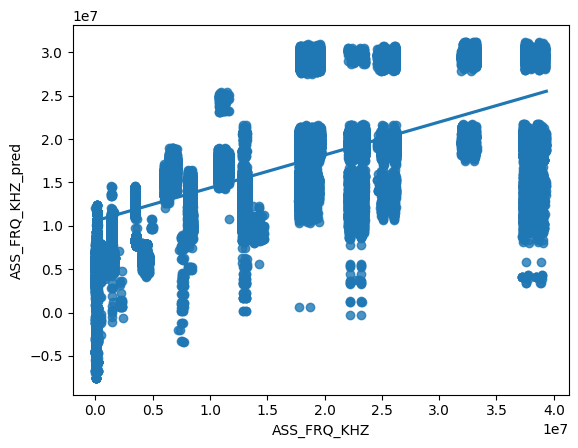

In [ ]:
# prompt: fais une regression pour predire la frequence

import numpy as np
from sklearn.linear_model import LinearRegression

# Create a linear regression model
model = LinearRegression()

# Prepare the data
X = df_standardized[['ASS_LGBD_KHZ', 'longitude', 'latitude', 'Date CAF', 'Code CAF']]
y = df2['ASS_FRQ_KHZ']

# Train the model
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Evaluate the model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, y_pred)
print('Mean squared error:', mse)

# r^2
from sklearn.metrics import r2_score
r2 = r2_score(y, y_pred)
print('R-squared:', r2)

#regression plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(x=y, y=y_pred)
plt.xlabel('ASS_FRQ_KHZ')
plt.ylabel('ASS_FRQ_KHZ_pred')
plt.show()

#

In [ ]:
# prompt: identifier les bandes de spectres qui pourrait etre remplacer par d'autre bandes de frequences

# Calculate the difference between the predicted and actual frequency bands
diff = df_evolution_grouped['Prediction'] - df_evolution_grouped['ASS_FRQ_KHZ']

# Identify the dates where the difference is the largest
dates_with_largest_diff = diff.sort_values(ascending=False).head(10).index

# Print the dates and the corresponding frequency bands
for date in dates_with_largest_diff:
    print(f"Date: {date}, Difference: {diff[date]:.2f}")

# Further analysis:
# - Investigate the specific reasons for the large differences on these dates.
# - Explore alternative frequency bands that could be used to replace the current ones.
# - Consider factors such as availability, cost, and performance when selecting replacement bands.
